A partir de una tabla de datos ya procesada para utilizar con los modelos teoricos, 
en este nb buscamos optimizar

In [8]:
## seteamos los parametros del notebook
%autosave 180

Autosaving every 180 seconds


In [9]:
import pandas as pd; 
import numpy as np; 
import os;
import random;
import time
%matplotlib inline

In [10]:
from utils.partitions import *
import utils.presto_connection as p_c

In [1]:
np.random.seed(2015)
#rootdir=os.getcwd()
rootdir = os.path.expanduser('~/mobility-study/')
os.chdir(rootdir)

run_number = 0

NameError: name 'np' is not defined

In [13]:
#from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
#NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler, SMOTE,\
#SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

In [91]:
ls datasets/

dafiti_01040804.csv.gz        dafiti_test.csv.gz
dafiti_01040804_query.csv.gz  foodpandas_01040804.csv.gz
dafiti_25033103.csv.gz        foodpandas_01040804_query.csv.gz
dafiti_25033103_query.csv.gz  foodpandas_28030104.csv.gz
dafiti_2days_events.csv.gz


In [92]:
train_file = "datasets/{ds:0=2d}{ms:0=2d}{de:0=2d}{me:0=2d}.csv.gz".format( ds=28,ms=3, 
             de = 1, me = 4)
train_table = pd.read_csv(train_file,sep = "|",
                   header =0,
                     index_col =0)

X_train = train_table[train_table.columns[:-1]].values
y_train = train_table[train_table.columns[-1:]].values.flatten()

In [93]:
test_file = "datasets/{ds:0=2d}{ms:0=2d}{de:0=2d}{me:0=2d}.csv.gz".format(  ds=1,ms=4,
            de = 8, me = 4)
test_table = pd.read_csv(test_file,sep = "|",
                   header =0,
                     index_col =0)

X_test = test_table[test_table.columns[:-1]].values
y_test = test_table[test_table.columns[-1:]].values.flatten()
del test_table

In [63]:
y_test = y_test.flatten()

## Scikit estimator fit and cross-validation

In [37]:
from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.neural_network import *
from sklearn.cross_validation import *
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import *
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.grid_search import *
from sklearn.pipeline import Pipeline

/home/teo/Repositories/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/teo/Repositories/scikit-learn/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [42]:
X_test.shape, y_test.shape

((211018, 234), (211018, 1))

In [49]:
#elegimos algunas variantes del dataset original
X_scaled= scale(X_train)

perc = 0.2
mini_ind = np.random.choice(X_train.shape[0],int(perc*X_train.shape[0]),replace=False)
X_mini =  X_train[mini_ind,:]
y_mini = y_train[mini_ind]

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((96341, 234), (96341, 1), (211018, 234), (211018, 1))

In [14]:
## seteo los generalizadores de CV
##genero los estimadores
W = np.array([15 if i == 1 else 1 for i in y])
#model = GradientBoostingClassifier()

gradboost = GradientBoostingClassifier( loss = 'deviance',n_estimators=20, 
                                       max_depth = 20
                                 )
svc = LinearSVC(C=2.0, tol = 1e-4,
                class_weight = 'balanced'
               )

svc2 = SVC(C=2.0, kernel = 'rbf' ,decision_function_shape='ovr',tol = 1e-5,
                class_weight = 'balanced', max_iter = 1000
               )


## TensorFlow classifiers -  scaled

In [14]:
import tensorflow as tf
import skflow

ImportError: No module named 'tensorflow'

In [ ]:
start_time = time.time()

X_cols = [col for col in X_train.columns if not('recency' in col ) and\
             not('truth' in col ) and not ( 'virality' in col )]

X = X_train[X_cols].values
# pero tenemos que transformar a y en un vector canonico indicando en 1 en la posicion correspondiente a su categoria
#y =  label_binarize(X_train['ground_truth'].values.astype(int),
#                    classes=list(set(X_train['ground_truth'].values.astype(int))))
y = X_train['ground_truth'].values
X_scaled= scale(X)

perc = 0.4
mini_ind = np.random.choice(X.shape[0],int(perc*X.shape[0]),replace=False)
X_mini =  X[mini_ind,:]
y_mini = y[mini_ind]




validated = []
# Only take the first fold.
n_folds = 3
for i in range(n_folds):
    # Break up the dataset into non-overlapping training (75%) and testing
    # (25%) sets.
    skf = StratifiedKFold(y, n_folds=n_folds)
    train_index, test_index = next(iter(skf))

    X_train = X_scaled[train_index]
    y_train = y[train_index]
    X_train_mnb = X[train_index]

    X_test = X_scaled[test_index]
    X_test_mnb = X[test_index]
    y_test = y[test_index]
    
    n_classes = len(np.unique(y_train))

    n_samples, n_features = X_train.shape
    weights = n_samples*1.0 / (n_classes * np.bincount(y))

    x = tf.placeholder(tf.float32, [None, n_features])
    W = tf.Variable(tf.zeros([n_features, n_classes]))
    b = tf.Variable(tf.zeros([n_classes]))
    y2 = tf.nn.softmax(tf.matmul(x, W) + b)
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    cross_entropy = -tf.reduce_sum(y_*tf.log(y2))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)

    batch_size = 1000
    y_train_binary = np.asarray([[1,0]if val ==0 else [0,1] for val in y_train])
    y_test_binary = np.asarray([[1,0]if val ==0 else [0,1] for val in y_test])
    
    n_batches = int(np.floor(len(X_train)*1.0/batch_size))

    for i in range(n_batches):
        n = random.randint(0,n_batches)
        batch_xs, batch_ys = X_train[n:(n+1)*1000,:], y_train_binary[n:(n+1)*1000]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    #aca la prediccion esta en y2
    correct_prediction = tf.equal(tf.argmax(y2,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    print(sess.run([accuracy], feed_dict={x: X_test, y_: y_test_binary}))

time.time() - start_time
print('This cell took %s seconds to run' % (time.time() - start_time))

In [ ]:
sart_time = time.time()

X_cols = [col for col in X_train.columns if not('recency' in col ) and\
             not('truth' in col ) and not ( 'virality' in col )]

X = X_train[X_cols].values
# pero tenemos que transformar a y en un vector canonico indicando en 1 en la posicion correspondiente a su categoria
#y =  label_binarize(X_train['ground_truth'].values.astype(int),
#                    classes=list(set(X_train['ground_truth'].values.astype(int))))
y = X_train['ground_truth'].values
X_scaled= scale(X)

perc = 0.4
mini_ind = np.random.choice(X.shape[0],int(perc*X.shape[0]),replace=False)
X_mini =  X[mini_ind,:]
y_mini = y[mini_ind]

#set classifiers params
n_classes =2
n_samples = len(X_train)

weights = n_samples*1.0 / (n_classes * np.bincount(y))

linear_clf = skflow.TensorFlowLinearClassifier(n_classes=n_classes)
clf = skflow.TensorFlowClassifier(n_classes=n_classes)

def exp_decay(global_step):
    learning_rate=0.1
    decay_steps=3 
    decay_rate=0.01
    return tf.train.exponential_decay(learning_rate,global_step,
                                      decay_steps, decay_rate)

dnn =skflow.TensorFlowDNNClassifier(hidden_units=[10, 20, 10], n_classes=n_classes,optimizer='Adagrad',
                              learning_rate = exp_decay )
#rnn = skflow.TensorFlowRNNClassifier(hidden_units=[10, 20, 10], n_classes=2,optimizer='Adagrad',
#                              )


validated = []
# Only take the first fold.
n_folds = 3
for i in range(n_folds):
    # Break up the dataset into non-overlapping training (75%) and testing
    # (25%) sets.
    skf = StratifiedKFold(y, n_folds=n_folds)
    train_index, test_index = next(iter(skf))


    X_train = X_scaled[train_index]
    y_train = y[train_index]
    X_train_mnb = X[train_index]

    X_test = X_scaled[test_index]
    X_test_mnb = X[test_index]
    y_test = y[test_index]
    
    n_classes = len(np.unique(y_train))

    # eventualmente podemos recorrer sobre distintos estimadores
    classifiers = { 'Deep NN':dnn,
                  'Linear Classifier':linear_clf, 'Classifier':clf}
    
    for index, (name, classifier) in enumerate(classifiers.items()):
        # Entrenar los parameters usando los trainig sets
        
        #cuidado con que MNB solo acepta features positivos
        if name == "MultinomialNB":
            classifier.fit(X_train_mnb,y_train)
            predictions = classifier.predict(X_test_mnb)
        else:
            classifier.fit(X_train,y_train)
            predictions = classifier.predict(X_test)
        
        expected = y_test
        if i==0:
            validated += [classification_report(expected, predictions)]
            continue
        
i=0
for index, (name, classifier) in enumerate(classifiers.items()):
    print("\n Full Classification Reports for classifier %s" %name)
    print(validated[i])
    i+=1
    
for index, (name, classifier) in enumerate(classifiers.items()):
    if name == "Linear SVM":
        continue
    print("\n Threshold Classification Reports for classifier %s" %name)
    predicted_proba = pd.DataFrame()
    predicted_proba['prob'] = classifier.predict_proba(X_test).max(axis=1)
    predicted_proba['gt'] = y_test
    predicted_proba['class'] = classifier.predict(X_test)

    threshold = 0.8
    ind = predicted_proba['prob']>threshold
    print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

       
all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)


In [ ]:
tf.train.exponential_decay?

## Cross Validate SGD

In [36]:
start_time = time.time()

param_grid = [
  { 'alpha': [1e-3,5*1e-3,1e-2], 'l1_ratio': [3*1e-2,1e-3,6*1e-4], 'n_iter': [2,3],
 
  }
 ]
sgd = SGDClassifier(loss='modified_huber', penalty='elasticnet', 
             fit_intercept=True,  shuffle=True, 
                    n_jobs=3,learning_rate='optimal', power_t =2, eta0 =5,
                    class_weight='balanced', average=40)

clf =GridSearchCV(sgd, param_grid, scoring='f1', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)



predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1

all_time =   time.time() - start_time

print('This cell took %s seconds to run' % all_time)
finished = True


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] alpha=0.001, l1_ratio=0.03, n_iter=2 ............................
[CV] alpha=0.001, l1_ratio=0.03, n_iter=2 ............................
[CV] alpha=0.001, l1_ratio=0.03, n_iter=2 ............................
[CV] ... alpha=0.001, l1_ratio=0.03, n_iter=2, score=0.109714 -   0.4s
[CV] alpha=0.001, l1_ratio=0.03, n_iter=3 ............................
[CV] ... alpha=0.001, l1_ratio=0.03, n_iter=2, score=0.106493 -   0.4s
[CV] alpha=0.001, l1_ratio=0.03, n_iter=3 ............................
[CV] ... alpha=0.001, l1_ratio=0.03, n_iter=2, score=0.106978 -   0.4s
[CV] alpha=0.001, l1_ratio=0.03, n_iter=3 ............................
[CV] alpha=0.001, l1_ratio=0.001, n_iter=2 ...........................
[CV] ... alpha=0.001, l1_ratio=0.03, n_iter=3, score=0.110516 -   0.6s
[CV] alpha=0.001, l1_ratio=0.001, n_iter=2 ...........................
[CV] ... alpha=0.001, l1_ratio=0.03, n_iter=3, score=0.109154 -   0.6s
[CV] alpha=0.001

Process PoolWorker-13:
Traceback (most recent call last):
Process PoolWorker-14:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


[CV] alpha=0.001, l1_ratio=0.0006, n_iter=3 ..........................


KeyboardInterrupt: 

In [ ]:
clf.best_estimator_

In [ ]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

### Results
* l1_ratio = cuanto mas chico mejor con lo cual la perdida l2 parece ser mejor
* alpha = 1e-3 es suficiente pues casi no afecta el score
* power_t = muy variado, no parece haber correlacion entre el tamanyo y el avg, mean_score
* eta0 = no afecta mucho pero parece ser que con ser >1 ya esta
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

## Cross Validate NN

In [35]:
start_time = time.time()

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

param_grid = { 'alpha': [1e-1,5*1e-2,1e-2],
              'hidden_layer_sizes':[(50,),(10,5)],
              'learning_rate': ['adaptive',"invscaling"],
              "algorithm": ['adam','sgd'],
  'power_t': [1e-3, 5*1e-4, 1e-5], 'activation':['logistic','relu']
 }

mlp = MLPClassifier(shuffle=True, 
                 verbose=True)

clf =GridSearchCV(mlp, param_grid, scoring='f1', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive 
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 
Iteration 1, loss = 0.20405210
Iteration 1, loss = 0.20380843
Iteration 1, loss = 0.20378706
Iteration 1, loss = 0.20405210


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.5s
[CV] algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.0005, alpha=0.1, learning_rate=adaptive 


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.7s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   2.1s


/home/teo/Repositories/scikit-learn/sklearn/metrics/classification.py:1097: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  algorithm=adam, hidden_layer_sizes=(50,), activation=logistic, power_t=0.001, alpha=0.1, learning_rate=adaptive, score=0.000000 -   1.9s


KeyboardInterrupt: 

In [1]:
clf.best_estimator_

NameError: name 'clf' is not defined

In [ ]:
# compare best parameters to tune
coln=6
cv_result.groupby(cv_result.columns[coln])['mean_score'].mean()
cv_result.groupby(cv_result.columns[coln])['mean_score'].std()

### Results
* activation = logistic es 10% mejor
* alpha = 1e-2 el mejor 
* power_t = cuanto mas chico mejor, 1e-3 por lo menos
* hidden_layer_size = menos layers es mejor..?
* power_t = parecen ser practicamente iguales
* n_iter = cuanto mas iter NO mejora el score

## Bernoulli RBM features selection & Logit crossval

In [127]:
start_time = time.time()

## obs. este metodo es especial y asume que todos los valores son True/False o que \in [0,1]
# luego tengo que pensar en como tomar los features nuevamente.
# tampoco 'fittea' en la forma tradicional. Sino que se le puede tomar al y como un feature mas y esta red
# va 'modificando' todos los valores del X (minimizando la entropia) para dar un output. Luego corriendo 
# clf.gibbs(X_test) con el y_test como feature tmb, nos transforma la data para ver el output como la 'prediccion'
# obviamente no tiene probabilidades


#X = X_train[X_cols].values
#y = X_train['ground_truth'].values

df = X_train.drop(X_train[X_train[X_train.columns[0:3]].\
                                   sum(axis=1)==0].index)
df = df[X_cols + ['ground_truth']]

for col in X_train.columns[0:3]:
    df[col] = df[col]*1.0/df[df.columns[0:3]].sum(axis=1)

df[df.columns[3]] =  df[df.columns[3]]/df[df.columns[3]].max()
df[df.columns[4]] =  df[df.columns[4]]/df[df.columns[4]].max()

X = df[df.columns[:-1]].values
y = df['ground_truth'].values


param_grid = {'rbm__n_components': [256, 128,46,10],
   'rbm__n_iter':[15,10,5], 'rbm__learning_rate': [1e-4,1e-3,1e-2,1e-1,5*1e-3,5*1e-2,5*1e-1],
  'rbm__batch_size': [10e4,3*10e3, 1e3, 300],"logistic__C": [1.0, 10.0, 100.0] 
 }

rbm = BernoulliRBM(verbose=True)
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

clf =GridSearchCV(classifier, param_grid, scoring='f1', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

#este metodo NO tiene predicted proba, lo que hacemos es recorrer 
#predicted_labels = rbm.gibbs(X_test)[:,-1]
#real_labels = X_test[:,-1]
#print(classification_report(real_labels,predicted_labels ))


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))
all_time =   time.time() - start_time

finished = True

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
    
print('This cell took %s seconds to run' % all_time)


KeyboardInterrupt: 

In [ ]:
coln=1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

## ADaboost CV

In [41]:
rf_param_grid = {'n_estimators': [10, 30, 100, 300, 1000]}
boost_param_grid = {'n_estimators': [10, 30, 100, 300, 1000],
                      'max_depth': [2, 3, 4, 5],
                      'min_samples_leaf': [1, 2, 3]}
ada_param_grid = {'n_estimators': [10, 30, 100, 300, 1000],
                   'learning_rate': [0.1, 0.3, 1.0, 3.0]}

X_train,X_test,y_train ,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
#rf_est = RandomForestClassifier()
#rf_gs_cv = GridSearchCV(rf_est, rf_param_grid).fit(X_train, Y_train)
#print(rf_gs_cv.best_score_, rf_gs_cv.best_params_)
print('\n')
 
#boost_est = GradientBoostingClassifier()
#boost_gs_cv = GridSearchCV(boost_est, boost_param_grid).fit(X_train, y_train)
#print(boost_gs_cv.best_score_, boost_gs_cv.best_params_)
print('\n')
 
ada_est = AdaBoostClassifier()
ada_gs_cv = GridSearchCV(ada_est, ada_param_grid).fit(X_train, y_train)
print(ada_gs_cv.best_score_, ada_gs_cv.best_params_)
print('\n')

KeyboardInterrupt: 

In [42]:
start_time = time.time()


param_grid = {'n_estimators': [200,600,60,45,30,15],
 'learning_rate': [1e-4,1e-3,1e-2,1e-1,5*1e-3,5*1e-2,5*1e-1]
 }

aboost = AdaBoostClassifier(algorithm='SAMME.R')

clf =GridSearchCV(aboost, param_grid, scoring='f1', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))
all_time =   time.time() - start_time

print('This cell took %s seconds to run' % all_time)

finished = True
#este flag es basicamente para chequear 

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1

finished = True

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV] n_estimators=200, learning_rate=0.0001 ..........................
[CV] n_estimators=600, learning_rate=0.0001 ..........................
[CV] n_estimators=600, learning_rate=0.0001 ..........................


KeyboardInterrupt: 

In [23]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


criterion
gini    0.802919
Name: mean_score, dtype: float64
criterion
gini    0.000598
Name: mean_score, dtype: float64


## CrossV SVC

array([ 14126, 256042])

In [ ]:
start_time = time.time()

param_grid = [{'kernel': ['rbf'], 'gamma': list(10.0 ** np.arange(-2, 3)),
                     'C': list(10.0 ** np.arange(0, 4))},
                    {'kernel': ['poly'], 'C': list(10.0 ** np.arange(0, 4)), 'degree'[2,3,4]}]

svc = SVC(shuffle=True, probability=True,decision_function_shape = 'ovr',
           verbose=True, class_weight='balanced'
          )

clf =GridSearchCV(svc, param_grid, scoring='f1', fit_params=None, n_jobs=4, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

clf.fit(X_train,y_train)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['gt'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.7
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

In [ ]:
coln=3
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())


In [214]:
#tomo tiempo para saber cuanto tarda fitear el estimador
start_time = time.time()

#model = model.fit(X,y,sample_weight=W)

W = np.array([10 if i == 1 or i ==2  else 1 for i in y_mini])
gradboost.fit(X_mini,y_mini, sample_weight=W)

elapsed_time =   time.time() - start_time
print('GradientBoosting took %s seconds to run' % elapsed_time)

#validated =  cross_val_score(gradboost,X,y,cv=5, scoring = "f1_weighted")


all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

GradientBoosting took 117.26272392272949 seconds to run
This cell took 117.26284193992615 seconds to run


## Timings
* 5s con  10 n_estimadores, 15 max_depth y X.sample(0.2)
* 15s con 10 n_estimadores, 15 max_depth y X.sample(0.2)
* 47s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 35s con 10 n_estimadores, 15 max_depth y X.sample(0.4)
* 117 con 20 n_estimadores, 20 max_depth y X.sample(0.4)

In [31]:
X_train['ground_truth'].value_counts()

0    128153
1      7064
Name: ground_truth, dtype: int64

## Cross Validate - Random Forest

In [ ]:
param_grid = {'criterion': ['gini','entropy'], 'n_estimators': [30,50,60],
  'max_features': ["auto", "log2", "None"], "bootstrap": [ False],
    "min_samples_leaf": np.append(np.random.randint(1,11,3),[1]),'max_depth':[3,10, 15], 
              "min_samples_leaf": [1, 3, 10], "class_weight": ["None",'balanced']
              }

In [94]:
start_time = time.time()
param_grid = {'max_depth':[20], 'n_estimators': [8,20],
             "class_weight": ['balanced'],'criterion': ['gini'],
              "bootstrap":[False], "min_samples_leaf": [10,15]              
              }


rforest  = RandomForestClassifier( )

clf =GridSearchCV(rforest, param_grid, scoring='f1', fit_params=None, n_jobs=3, iid=True, refit=True, 
verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

#how many parameters to randomly search for
#n_iter_search = 45

#random_search = RandomizedSearchCV(rforest, param_distributions=param_grid,
                                 #  n_iter=n_iter_search, n_jobs =8, verbose=3)
#random_search.fit(X_train,y_train)
elapsed_time =  time.time() - start_time
print('Random Search took %s seconds to run' % elapsed_time)

clf.fit(X_train,y_train)

all_time =   time.time() - start_time 
print('Grid Search took %s seconds to run' % (all_time - elapsed_time))

print('This cell took %s seconds to run' % all_time)

predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['y'] = y_test
predicted_proba['class'] = clf.predict(X_test)

threshold = 0.55
ind = predicted_proba['prob']>threshold

print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))

all_time =   time.time() - start_time


cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1
#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

Random Search took 0.00039005279541 seconds to run
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV] bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.787413 -   2.8s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.784558 -   3.6s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.789583 -   4.2s
[CV] bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.788728 -   6.8s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.784088 -   7.6s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.785184 -   2.6s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=10, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.789019 -   8.0s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.789167 -   2.5s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


[Parallel(n_jobs=3)]: Done  13 out of  12 | elapsed:   15.3s remaining:   -1.2s
/home/teo/Repositories/scikit-learn/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=8, criterion=gini, max_depth=20, class_weight=balanced, score=0.784265 -   4.2s
[CV] bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced 


[Parallel(n_jobs=3)]: Done  13 out of  12 | elapsed:   16.3s remaining:   -1.3s


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.790481 -   6.8s


[Parallel(n_jobs=3)]: Done  13 out of  12 | elapsed:   20.3s remaining:   -1.6s


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.783618 -   5.9s


[Parallel(n_jobs=3)]: Done  13 out of  12 | elapsed:   21.2s remaining:   -1.6s


[CV]  bootstrap=False, min_samples_leaf=15, n_estimators=20, criterion=gini, max_depth=20, class_weight=balanced, score=0.788395 -   6.5s


[Parallel(n_jobs=3)]: Done  13 out of  12 | elapsed:   22.8s remaining:   -1.8s
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   22.8s finished


Grid Search took 27.5189659595 seconds to run
This cell took 27.5193560123 seconds to run
             precision    recall  f1-score   support

          0       1.00      0.81      0.89     91458
          1       0.68      0.99      0.81     38026

avg / total       0.90      0.86      0.87    129484



In [95]:
np.bincount(y_train),np.bincount(y_test)

(array([63738, 21095]), array([93875, 38673]))

In [79]:
np.bincount(y_train),np.bincount(y_test)

array([93764,  2577])

In [98]:
threshold = 0.9
ind = predicted_proba['prob']>threshold

print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))


             precision    recall  f1-score   support

          0       1.00      0.98      0.99     73187
          1       0.89      0.99      0.94     13935

avg / total       0.98      0.98      0.98     87122



In [99]:
coln=6
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].std())

class_weight
balanced    0.787042
Name: mean_score, dtype: float64
class_weight
balanced    0.000573
Name: mean_score, dtype: float64


### Results
* bootstrap  = False es 5% mejor
* min_samples_leaf = mas grande parece mejor pero el std error tmb crece y es igual el score
* n_estimatores = aumentar mas de 30 no tendria mucho sentido
* citerion = entropy o gini no cambia. gini podria ser mejor entonces pues entropy usa logs de los valores lo cual es mas computacionalmente costoso
* max_features = no afecta al score. con auto esta bien
* max_depth =  mas es mejor. intentaria probar con >15

In [69]:
start_time = time.time()
#param_grid = {'max_depth':[20], 'n_estimators': [8,20],
#             "class_weight": ['balanced'],'criterion': ['gini'],
#              "bootstrap":[False], "min_samples_leaf": [10,15]
 #             }


mnb  = MultinomialNB( )

#clf =GridSearchCV(mnb,  scoring='f1', fit_params=None, n_jobs=3, iid=True, refit=True, 
#verbose=3, pre_dispatch='2*n_jobs', error_score='raise')

#how many parameters to randomly search for
#n_iter_search = 45

mnb.fit(X_train,y_train)


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = mnb.predict_proba(X_test).max(axis=1)
predicted_proba['y'] = y_test
predicted_proba['class'] = mnb.predict(X_test)

threshold = 0.55
ind = predicted_proba['prob']>threshold

all_time =   time.time() - start_time

print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))

#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

print('This cell took %s seconds to run' % all_time)


             precision    recall  f1-score   support

          0       0.99      0.85      0.92    203457
          1       0.14      0.70      0.23      6773

avg / total       0.96      0.85      0.89    210230

This cell took 0.414650917053 seconds to run


## Cross Validate ExtraTreeClassifier

In [77]:
whos

Variable                                Type                          Data/Info
-------------------------------------------------------------------------------
ARDRegression                           ABCMeta                       <class 'sklearn.linear_mo<...>del.bayes.ARDRegression'>
AdaBoostClassifier                      ABCMeta                       <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
AdaBoostRegressor                       ABCMeta                       <class 'sklearn.ensemble.<...>sting.AdaBoostRegressor'>
BaggingClassifier                       ABCMeta                       <class 'sklearn.ensemble.<...>gging.BaggingClassifier'>
BaggingRegressor                        ABCMeta                       <class 'sklearn.ensemble.<...>agging.BaggingRegressor'>
BaseEnsemble                            type                          <class 'sklearn.ensemble.base.BaseEnsemble'>
BayesianRidge                           ABCMeta                       <class 'sklearn.linear_mo

## Cross validate MNB

In [72]:
start_time = time.time()

# pero tenemos que transformar a y en un vector canonico indicando en 1 en la posicion correspondiente a su categoria
#y =  label_binarize(X_train['ground_truth'].values.astype(int),
#                    classes=list(set(X_train['ground_truth'].values.astype(int))))

perc = 0.3
mini_ind = np.random.choice(X_train.shape[0],int(perc*X_train.shape[0]),replace=False)
#X_mini =  X[mini_ind,:]
#y_mini = y[mini_ind]


clf = MultinomialNB(
        )

validated = []
# Only take the first fold.
n_folds = 4
for i in range(n_folds):
    # Break up the dataset into non-overlapping training (75%) and testing
    # (25%) sets.
    skf = StratifiedKFold(y_train, n_folds=n_folds)
    train_index, test_index = next(iter(skf))

    X_traincv = X_train[train_index]
    y_traincv = y_train[train_index]

    n_classes = len(np.unique(y_traincv))

    clf.fit(X_traincv,y_traincv)
    predictions = clf.predict(X_traincv)
        
    expected = y_traincv

    print(classification_report(expected, predictions))


predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(X_test).max(axis=1)
predicted_proba['y'] = y_test
predicted_proba['class'] = clf.predict(X_test)


#este flag es basicamente para chequear que hayamos terminado nomas
finished = True

all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)


             precision    recall  f1-score   support

          0       0.99      0.85      0.91     70323
          1       0.12      0.73      0.20      1932

avg / total       0.97      0.84      0.89     72255

             precision    recall  f1-score   support

          0       0.99      0.85      0.91     70323
          1       0.12      0.73      0.20      1932

avg / total       0.97      0.84      0.89     72255

             precision    recall  f1-score   support

          0       0.99      0.85      0.91     70323
          1       0.12      0.73      0.20      1932

avg / total       0.97      0.84      0.89     72255

             precision    recall  f1-score   support

          0       0.99      0.85      0.91     70323
          1       0.12      0.73      0.20      1932

avg / total       0.97      0.84      0.89     72255

This cell took 1.06442093849 seconds to run


In [76]:
threshold = 0.99
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'y'].values,predicted_proba.loc[ind,'class'].values ))


             precision    recall  f1-score   support

          0       0.99      0.87      0.93    185744
          1       0.15      0.73      0.26      5906

avg / total       0.96      0.87      0.91    191650



In [ ]:
predicted_proba[predicted_proba['class1']>0]['class1'].hist()

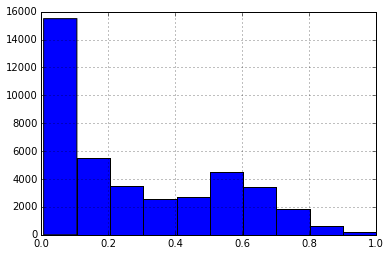

In [40]:
predicted_proba[predicted_proba['class2']>0]['class2'].hist()

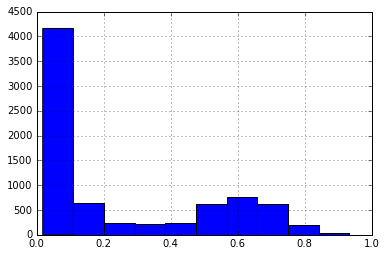

In [162]:
predicte_proba[predicte_proba['class3']>0]['class3'].hist()

In [165]:
X_train.head()

,Event_view_product,Event_product_rate,Event_sale,virality,recency_days,os_version,display_size,manufacturer_LGE,manufacturer_Sony,manufacturer_asus,...,model_XT1097,model_XT1225,model_XT1563,country_ar,country_br,country_cl,country_co,country_mx,country_us,ground_truth
ref_hash,,,,,,,,,,,,,,,,,,,,,
aeddfaf288ee5aaf,17634.906342,0,0,50.385447,0.995370,16,58,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2746037055b12162,2708.217760,0,0,451.369627,0.111111,19,41,0,0,0,...,0,0,0,0,1,0,0,0,0,0
f0bcb409bf0636ff,1805.478506,0,0,451.369627,0.111111,19,42,0,0,0,...,0,0,0,0,1,0,0,0,0,0
eea677c130bf8889,1327.557725,0,0,53.102309,0.944444,16,58,0,0,0,...,0,0,0,0,1,0,0,0,0,0
eaa491185356c618,541.643552,0,0,108.328710,0.462963,18,48,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [166]:
start_time = time.time()

havent_converted = X_train[X_train['Event_sale']==0][X_cols].values
havent_converted_gt = X_train[X_train['Event_sale']==0]['ground_truth'].values

predictions = rforest.predict(havent_converted)
expected = havent_converted_gt
print(classification_report(expected, predictions))

all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

             precision    recall  f1-score   support

          0       1.00      0.97      0.98    120717
          1       0.53      0.87      0.66      3917
          2       0.47      0.91      0.62       815

avg / total       0.98      0.96      0.97    125449

This cell took 1.5365548133850098 seconds to run


In [140]:
start_time = time.time()

predictions = mnb.predict(X_test)
expected = y
print(classification_report(expected, predictions))

all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

             precision    recall  f1-score   support

          0       0.97      0.83      0.89    128823
          1       0.07      0.25      0.11      4998
          2       0.07      0.39      0.12      1396

avg / total       0.93      0.80      0.86    135217

This cell took 0.07135701179504395 seconds to run


In [60]:
#tomo tiempo para saber cuanto tarda fitear el estimador
start_time = time.time()

svc2.fit(X_mini,y_mini)
elapsed_time =   time.time() - start_time
print('SVC took %s seconds to run' % elapsed_time)

all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

SVC took 362.8217749595642 seconds to run
This cell took 362.8219118118286 seconds to run


## Timings
* 40k samples : 360s
* 

In [75]:
start_time =  time.time()
lr.fit(X_train,y_train)
elapsed_time =   time.time() - start_time
print('Logit took %s seconds to run' % elapsed_time)

Logit took 1073.0756621360779 seconds to run


In [ ]:
#tomo tiempo para saber cuanto tarda fitear el estimador
start_time = time.time()

lr.fit(X_train,y_train)
elapsed_time =   time.time() - start_time
print('Logit took %s seconds to run' % elapsed_time)

svc.fit(X_train,y_train)
elapsed_time =   time.time() - start_time
print('Linear SVC took %s seconds to run' % elapsed_time)

all_time =   time.time() - start_time
print('This cell took %s seconds to run' % all_time)

Logit took 89.15975689888 seconds to run
Linear SVC took 804.7178750038147 seconds to run

In [ ]:
y.value_counts

In [ ]:
X_train['ground_truth'].value_counts

In [76]:
predictions = lr.predict(X_test)
expected = y
print(classification_report(expected, predictions))

             precision    recall  f1-score   support

          0       0.97      0.83      0.90    128823
          1       0.09      0.24      0.13      5902
          2       0.03      0.52      0.06       492

avg / total       0.93      0.81      0.86    135217



In [87]:
svc.fit(X_train,y_train)
predictions = svc.predict(X_test)
expected =y 
print(classification_report(expected, predictions))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97    128153
          1       0.00      0.00      0.00      7064

avg / total       0.90      0.95      0.92    135217



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")


## Pickup Markov-Model output files

In [55]:
markov_table = pd.DataFrame()
directory = os.path.join(os.getcwd()+"/markov_output/" ,"")
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            #print(file)
            df = pd.read_csv(directory +file,
                   header =None)
            df.columns = ['ref_hash']
            #asigno el grupo segun el file que estoy levantando
            df['predict_markov'] = 4-int(file.replace(".csv","")[-1])
            
            markov_table = pd.concat([markov_table,df])

In [56]:
#recategorizo markov en solo 3 categorias
markov_table.loc[markov_table['predict_markov']==3,'predict_markov']=2
markov_table.shape

(20068, 2)

In [57]:
markov_table.describe()

,predict_markov
count,20068.000000
mean,1.250000
std,0.829177
min,0.000000
25%,0.750000
50%,1.500000
75%,2.000000
max,2.000000


In [249]:
#chequeamos la consistencia de los datos
markov_table['ref_hash'].isin(X_train.index.values).sum()

In [ ]:
a = result

In [251]:
markov_table = markov_table.join(X_train, on = 'ref_hash',how = 'inner')
markov_table = markov_table[['ref_hash','predict_markov','ground_truth']]

In [252]:
#guardo en el .h5 local
store.open()
store['app_id_%s/markov'% (application_id)] = markov_table
store.close()

In [253]:
predictions = markov_table['predict_markov'].values
expected = markov_table['ground_truth'].values
print(classification_report(expected, predictions))

             precision    recall  f1-score   support

        0.0       0.95      0.25      0.40     19006
        1.0       0.05      0.26      0.08       960
        2.0       0.01      0.50      0.01       102

avg / total       0.90      0.25      0.38     20068



In [259]:
predictions = lr.predict(X_test)
output['predicted'] = predictions
expected = X_train['ground_truth']
print(classification_report(expected, predictions))

             precision    recall  f1-score   support

        0.0       0.97      0.85      0.91    168267
        1.0       0.08      0.17      0.11      7299
        2.0       0.03      0.56      0.05       640

avg / total       0.93      0.82      0.87    176206



In [255]:
X_train['ground_truth'].value_counts()

ground_truth
0    168267
1      7299
2       640
Name: ground_truth, dtype: int64

In [90]:
pd.Series.value_counts?

In [260]:
X_train['predicted'].value_counts()

predicted
0    148001
1     15273
2     12932
Name: predicted, dtype: int64

In [257]:
markov_table['ground_truth'].value_counts()

ground_truth
0    19006
1      960
2      102
Name: ground_truth, dtype: int64

## Como leer el Score
**Predicted_positive:** es un numero que varia por segmento y cuenta el numero total de usuarios que mi prediccion puso en ese segmento.

**Condition_positive:** para c/ segmento, cuenta el numero total de usuarios que realmente estan en ese segmento.

**True_positive:** para c/ segmento, cuenta el numero total de usuarios que predijimos en este segmento y realmente estan en ese segmento.

$Precision = \frac{TruePositive}{PredictedPositive}$

$Recall = \frac{TruePositive}{ConditionPositive}$

$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$


In [666]:
b = np.dot(a.transpose(), a)

## XGBoost section
Gradient boosting using xgboost dmlc tested library 
(google and kaggle.com)

In [43]:
#Parameter grid search with xgboost
#feature engineering is not so useful and the LB is so overfitted/underfitted
#so it is good to trust your CV
import xgboost as xgb
from sklearn import preprocessing
from sklearn.grid_search import *
X_cols = [col for col in X_train.columns if not('recency' in col ) and\
             not('truth' in col ) and not ( 'virality' in col )]

X = X_train[X_cols].values
# pero tenemos que transformar a y en un vector canonico indicando en 1 en la posicion correspondiente a su categoria
#y =  label_binarize(X_train['ground_truth'].values.astype(int),
#                    classes=list(set(X_train['ground_truth'].values.astype(int))))
y = X_train['ground_truth'].values
X_scaled= scale(X)

msk = np.random.rand(len(X_train)) < 0.75

train = X_train.iloc[msk,:].copy()
train = train[['ground_truth']+X_cols]

test = X_train.iloc[~msk,:].copy()
test = test[['ground_truth']+X_cols]

features = list(train.columns[1:])  #la colonne 0 est le quote_conversionflag  
print(features)


for f in train.columns:
    if train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

xgb_model = xgb.XGBClassifier()

['Event_view_product', 'Event_product_rate', 'Event_sale', 'os_version', 'display_size', u'manufacturer_LGE', u'manufacturer_Sony', u'manufacturer_asus', u'manufacturer_motorola', u'manufacturer_samsung', u'model_ASUS_T00J', u'model_ASUS_Z00AD', u'model_C6943', u'model_D5322', u'model_D5833', u'model_D6543', u'model_D6633', u'model_E2363', u'model_GT-I8190L', u'model_GT-I8200L', u'model_GT-I8262B', u'model_GT-I8552B', u'model_GT-I9060C', u'model_GT-I9063T', u'model_GT-I9082L', u'model_GT-I9192', u'model_GT-I9300', u'model_GT-I9300I', u'model_GT-I9500', u'model_GT-I9505', u'model_GT-I9515L', u'model_GT-N7100', u'model_GT-S7582L', u'model_LG-D337', u'model_LG-D385', u'model_LG-D410', u'model_LG-D805', u'model_LG-D855', u'model_MotoE2(4G-LTE)', u'model_MotoG3', u'model_SM-A300M', u'model_SM-A500M', u'model_SM-A700FD', u'model_SM-E500M', u'model_SM-E700M', u'model_SM-G3502T', u'model_SM-G355M', u'model_SM-G360BT', u'model_SM-G360M', u'model_SM-G3812B', u'model_SM-G530BT', u'model_SM-G530H'

In [44]:
#brute force scan for all parameters, here are the tricks

#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [1e-2,5*1e-3,1e-3],
              'max_depth': [15,20],
              'alpha': [0.5,0.1,0.01],
              'lambda': [1,0.5,0.1],
              'gamma': [1,2],
              'min_child_weight': [15,10],
              'silent': [1],
              'subsample': [0.75],
              'colsample_bytree': [0.7],
              'n_estimators': [30,50,80], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'n_estimators': [15,30],
              'seed': [1337]}


##  Best_Params
* learning_rate: betwween 0.01 to 0.1
* min_child_weight: >5 is better std error
* n_estimators: <30 is better std error
* max_depth: >15 is slightly slightly better in mean but slightly worse in std.


In [45]:
start_time = time.time()


clf = GridSearchCV(xgb_model, parameters, n_jobs=3, 
                   cv=StratifiedKFold(train['ground_truth'], n_folds=3, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], train["ground_truth"])

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

#sample = pd.read_csv('../input/sample_submission.csv')
#sample.QuoteConversion_Flag = test_probs
#sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

all_time =   time.time() - start_time 
print('This cell took %s seconds to run' % all_time)

Fitting 4 folds for each of 135 candidates, totalling 540 fits
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 -  10.4s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, 

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  7.4min


[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=1, n_estimators=80, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 -  59.4s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 -  15.7s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.05, nthread=3, min_child_weight=11, n_estimators=30, subsample=

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 31.9min


[CV] colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=5, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=11, n_estimators=80, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 -  28.7s
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=5, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 -  14.0s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=5, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=5, n_estimators=50, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.04, nthread=3, min_child_weight=5, n_estimators=30, subsample=0.75,

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 72.1min


[CV] colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=1, n_estimators=80, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=10 -  59.1s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 -  13.9s
[CV] colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, seed=1337, objective=binary:logistic, max_depth=5 
[CV]  colsample_bytree=0.7, silent=1, learning_rate=0.1, nthread=3, min_child_weight=11, n_estimators=30, subsample=0.75, 

[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed: 112.1min finished


('Raw AUC score:', 0.73675653453531542)
colsample_bytree: 0.7
learning_rate: 0.1
max_depth: 5
min_child_weight: 1
n_estimators: 80
nthread: 3
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 0.75
This cell took 6736.18098807 seconds to run


In [ ]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.04, 1e-2,0.1,0.5], #so called `eta` value
              'max_depth': [4,5,6],
              'min_child_weight': [2,3,1],
              'silent': [1],
              'subsample': [0.75],
              'colsample_bytree': [0.7],
              'n_estimators': [30,50,80], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [42]}


In [62]:
predictions =  clf.predict(test[features])
expected = test['ground_truth'].values
print(classification_report(expected, predictions))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97     32223
          1       0.38      0.00      0.00      1772

avg / total       0.92      0.95      0.92     33995



In [88]:
predicted_proba = pd.DataFrame()
predicted_proba['prob'] = clf.predict_proba(test[features])[:,1]
predicted_proba['gt'] = test['ground_truth'].values
predicted_proba['class'] = clf.predict(test[features])

threshold = 1e-1
ind = predicted_proba['prob']>threshold
print(classification_report(predicted_proba.loc[ind,'gt'].values,predicted_proba.loc[ind,'class'].values ))

In [91]:
cv_result = pd.DataFrame(columns=['mean_score' ] + [key for key, value in clf.grid_scores_[0].parameters.items() ] )
i=0
for setup in clf.grid_scores_:
    row = [clf.grid_scores_[i].mean_validation_score ] + [value for key, value in clf.grid_scores_[i].parameters.items() ]
    cv_result.loc[i] = row
    i+=1

In [92]:
cv_result

,mean_score,colsample_bytree,silent,learning_rate,nthread,min_child_weight,n_estimators,subsample,seed,objective,max_depth
0,0.734251,0.7,1.0,0.05,3.0,11.0,30.0,0.75,1337.0,binary:logistic,10.0
1,0.733508,0.7,1.0,0.05,3.0,11.0,50.0,0.75,1337.0,binary:logistic,10.0
2,0.733174,0.7,1.0,0.05,3.0,11.0,80.0,0.75,1337.0,binary:logistic,10.0
3,0.734326,0.7,1.0,0.05,3.0,5.0,30.0,0.75,1337.0,binary:logistic,10.0
4,0.733291,0.7,1.0,0.05,3.0,5.0,50.0,0.75,1337.0,binary:logistic,10.0
5,0.732507,0.7,1.0,0.05,3.0,5.0,80.0,0.75,1337.0,binary:logistic,10.0
6,0.734111,0.7,1.0,0.05,3.0,1.0,30.0,0.75,1337.0,binary:logistic,10.0
7,0.733195,0.7,1.0,0.05,3.0,1.0,50.0,0.75,1337.0,binary:logistic,10.0
8,0.732155,0.7,1.0,0.05,3.0,1.0,80.0,0.75,1337.0,binary:logistic,10.0
9,0.734849,0.7,1.0,0.05,3.0,11.0,30.0,0.75,1337.0,binary:logistic,5.0


In [113]:
coln = 1
print(cv_result.groupby(cv_result.columns[coln])['mean_score'].mean())
cv_result.groupby(cv_result.columns[coln])['mean_score'].std()

colsample_bytree
0.7    0.726528
Name: mean_score, dtype: float64


colsample_bytree
0.7    0.015647
Name: mean_score, dtype: float64

##  Best_Params
* learning_rate: betwween 0.01 to 0.1
* min_child_weight: >5 is better std error
* n_estimators: <30 is better std error
* max_depth: >15 is slightly slightly better in mean but slightly worse in std.
